# LigthGBM - CLASSIFICATION - BAYESIAN OPTIMIZATION

In [1]:
import numpy as np
from scipy.stats import uniform as sp_rand
from sklearn import datasets
import lightgbm as lgb
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
import pandas as pd
from datetime import datetime
from time import time

In [52]:
from sklearn.metrics import roc_auc_score, auc

In [3]:
import warnings
warnings.filterwarnings('ignore')

### GLOBAL VARIABLES

In [33]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 20
CV = 3
SCORE = 'roc_auc'
handlingnull = False
NJOBS = -1
USEGPU = False
NCLASS = 3 # number class to predict (if bivar set 0)

### LOAD DATASET

In [5]:
train_features = X = pd.read_pickle('data/processed/X.pkl')

In [6]:
train_labels = pd.read_pickle('data/processed/y.pkl')

In [7]:
y_train = train_labels.copy()

In [8]:
train_labels = train_labels['target']

In [9]:
campaign = pd.read_pickle('data/features/campaign_quarter_001.pkl')

In [10]:
digital = pd.read_pickle('data/features/digital_features_period_001.pkl')

In [11]:
rcc = pd.read_pickle('data/features/X_rcc_features_ten_001.pkl')

In [12]:
rcc.drop(['id_persona', 'codmes'], inplace=True, axis=1)

In [13]:
train_features = train_features.join(campaign).join(rcc).join(digital)

In [14]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(train_features.values, train_labels.values)

### TRAIN MODEL

#### Set Search hyperparameters

In [15]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
boosting = 'gbdt'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = [0.01] 


# A node is split only when the resulting split gives a positive reduction in the loss function. 
# Gamma specifies the minimum loss reduction required to make a split.
gamma = [i/10.0 for i in range(0,5)]


# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)scale_pos_weight = 1
scale_pos_weight = (len(train_labels) - sum(train_labels))/sum(train_labels)


# Learning Task Parameters
# This defines the loss function to be minimized. See documentation
# -  options: regression, regression_l1, huber, fair, poisson, quantile, 
# mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda,
# lambdarank, aliases: objective_type, app, application
objective  = 'binary'


# The metric to be used for validation data.
# - rmse, root square loss, aliases: root_mean_squared_error, l2_root
# - quantile, Quantile regression
# - mape, MAPE loss, aliases: mean_absolute_percentage_error
# - huber, Huber loss
# - fair, Fair loss
# - poisson, negative log-likelihood for Poisson regression
# - gamma, negative log-likelihood for Gamma regression
# - gamma_deviance, residual deviance for Gamma regression
# - tweedie, negative log-likelihood for Tweedie regression
# - ndcg, NDCG, aliases: lambdarank
# - map, MAP, aliases: mean_average_precision
# - auc, AUC
# - binary_logloss, log loss, aliases: binary
metric = 'auc'

[lightGBM params](https://lightgbm.readthedocs.io/en/latest/Parameters.html)


help(lgb.LGBMClassifier)

#### Define the search space

In [16]:
pds = {
    # Minimal number of data in one leaf. Can be used to deal with over-fitting
    # default = 20, type = int, aliases: min_data_per_leaf, min_data, min_child_samples, 
    'num_leaves': (20, 100),

    # Denotes the fraction of columns to be randomly samples for each tree.
    'feature_fraction': (0.1, 0.9),
    
    # Denotes the fraction of observations to be randomly samples for each tree.
    'bagging_fraction': (0.8, 1),

    # The maximum depth of a tree
    'max_depth': (9, 13 ),

    'min_split_gain': (0.001, 0.1),

    # Minimal sum hessian in one leaf. Like min_data_in_leaf, it can be used to deal with over-fitting
    # Default 1e-3
    'min_child_weight': (30, 50),    
}

In [17]:
pds

{'num_leaves': (20, 100),
 'feature_fraction': (0.1, 0.9),
 'bagging_fraction': (0.8, 1),
 'max_depth': (9, 13),
 'min_split_gain': (0.001, 0.1),
 'min_child_weight': (30, 50)}

#### Find num boost

In [18]:
early_stopping_rounds = 50

In [19]:
# specify your configurations as a dict
lgb_params = {
    'boosting_type': boosting,
    'objective': objective,
    'metric': metric,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads' : 8,
    'verbose': 0,
    #'num_class':  NCLASS,
    'seed' : SEED
}

In [20]:
cvresult = lgb.cv(lgb_params, lgb_train, num_boost_round = 1000, nfold = CV, metrics = metric, early_stopping_rounds = early_stopping_rounds, seed = SEED)

In [21]:
n_estimators = pd.DataFrame(cvresult).shape[0]

In [22]:
print("Best number of estimators found: ", n_estimators)

Best number of estimators found:  364


### Bayesian optimization hyperparameters

In [35]:
test_probs = []
test_auc = []

def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
      
    params = {'boosting_type': boosting,
              'objective': objective,
              'num_iterations': n_estimators,
              'learning_rate':eta, 
              #'early_stopping_round':50,
              'metric': metric,
              'seed':SEED} # Default parameters
    
    
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['min_split_gain'] = min_split_gain
    
    
    model = LGBMClassifier().set_params(**params)
    
    drop_cols = ["codmes"]
    
    
    for m in train_features.codmes.unique():
        Xt = train_features[train_features.codmes != m]
        yt = train_labels[train_labels.index.isin(Xt.index)]
        Xt = Xt.drop(drop_cols, axis=1)

        Xv = train_features[train_features.codmes == m]
        yv = train_labels[train_labels.index.isin(Xv.index)]
    
        
        res = model.fit(Xt, yt,  eval_metric=metric, verbose=False)
        
        pred = model.predict_proba(Xv.drop(drop_cols, axis=1))[:, -1]
    
        test_auc.append(roc_auc_score(yv.values, pred))
        
        test_probs.append(pd.Series(pred,
                                index=Xv.index, name="probs"))
        
        
    
    # Extract the best score
    best_score = np.mean(test_auc)
    
    # Loss must be minimized
    #loss = 1 - best_score

    return best_score

In [36]:
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=7)

In [37]:
# Optimize
optimizer.maximize(init_points=5, n_iter=NITER)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
|  1        |  0.7929   |  0.8153   |  0.7239   |  10.75    |  44.47    |  0.09782  |  63.08    |
|  2        |  0.7916   |  0.9002   |  0.1576   |  10.07    |  40.0     |  0.06824  |  84.3     |
|  3        |  0.7906   |  0.8762   |  0.1527   |  10.15    |  48.19    |  0.02213  |  56.17    |
|  5        |  0.7898   |  0.9818   |  0.2065   |  11.09    |  45.01    |  0.06723  |  57.42    |
|  6        |  0.7904   |  0.9684   |  0.5078   |  9.112    |  30.15    |  0.03288  |  99.99    |
|  7        |  0.7898   |  0.94     |  0.3149   |  9.255    |  30.21    |  0.06564  |  20.06    |
|  8        |  0.7903   |  0.9125   |  0.2489   |  11.83    |  49.99    |  0.06267  |  99.88    |
|  9        |  0.7907   |  0.9208   |  0.6397   |  10.54    |  30.12    |  0.04086  |  99.96    |
|  10       |  0.790

#### Best parameter

In [38]:
optimizer.max['params']

{'bagging_fraction': 0.8152616578747914,
 'feature_fraction': 0.7239350337920917,
 'max_depth': 10.753636925763574,
 'min_child_weight': 44.469303556618826,
 'min_split_gain': 0.09782096168766367,
 'num_leaves': 63.079669632834694}

#### Saving best hyperparameters

In [63]:
best_params = optimizer.max['params']

In [64]:
best_params['n_estimators'] = n_estimators

In [66]:
np.save('output/models/bayesianopt_gbm_classifier_bestparams_d' + str(datetime.now().date()) + '.npy', best_params)

#### Find best cutoff best

In [45]:
from scipy.optimize import differential_evolution

res = y_train.join(pd.concat(test_probs).rename("probs"))
optimization = differential_evolution(lambda c: -((res.probs > c[0]) * res.margen / res.margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.1384509243196543
 message: 'Optimization terminated successfully.'
    nfev: 107
     nit: 6
 success: True
       x: array([0.04843624])

In [56]:
cutoff = 0.04843624

In [53]:
def plot_roc_curve(true_labels, scores):
    ### actual code for roc + threshold charts start here 
    # compute fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr) # compute area under the curve

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    plt.show()
    
    pass

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import matplotlib.pyplot as plt

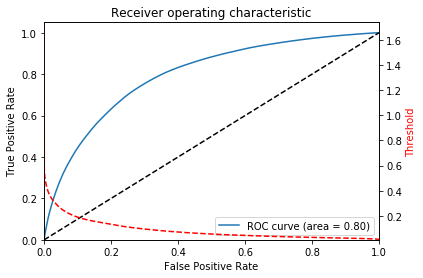

In [54]:
plot_roc_curve(res['target'], res['probs'])

In [57]:
# Find prediction to the dataframe applying threshold
res['pred'] = np.where(res.probs > cutoff,1,0)

In [60]:
# Print confusion Matrix
confusion_matrix(res['target'], res['pred'])

array([[2130137, 2666638],
       [  48878,  470972]])

In [61]:
res.shape

(5316625, 7)

In [59]:
from sklearn.metrics import confusion_matrix